In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

with open('SubTask C.2(FS) - GO/go_train_re_pairs.json', 'r') as f:
    train_data = json.load(f)

with open('SubTask C.2(FS) - GO/go_test_re_pairs.json', 'r') as f:
    test_data = json.load(f)

# Combine train and test data
combined_data = train_data + test_data

with open('SubTask C.2(FS) - GO/go_train_re_relations.txt', 'r') as f:
    relation_labels = [line.strip() for line in f.readlines()]

df = pd.DataFrame(combined_data)
print(f"Dataset shape: {df.shape}")
print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")
print(f"Relations: {relation_labels}")

relation_counts = df['r'].value_counts()
print(relation_counts)


Dataset shape: (17772, 3)
Train data size: 10538
Test data size: 7234
Relations: ['positively regulates', 'regulates', 'occurs in', 'has part', 'happens during']
r
part of                 7637
regulates               3329
positively regulates    2903
negatively regulates    2901
has part                 792
occurs in                197
happens during            13
Name: count, dtype: int64


In [2]:
df

,h,r,t
0,negative regulation of ferrichrome biosyntheti...,negatively regulates,ferrichrome biosynthetic process
1,erythropoietin-mediated signaling pathway,part of,cellular response to erythropoietin
2,negative regulation of mRNA processing,negatively regulates,mRNA processing
3,negative regulation of nitrogen compound metab...,negatively regulates,nitrogen compound metabolic process
4,generation of catalytic spliceosome for first ...,part of,spliceosomal conformational changes to generat...
...,...,...,...
17767,regulation of germ tube formation,regulates,germ tube formation
17768,regulation of late stripe melanocyte different...,regulates,late stripe melanocyte differentiation
17769,positive regulation of reciprocal meiotic reco...,positively regulates,reciprocal meiotic recombination
17770,regulation of telium development,regulates,telium development


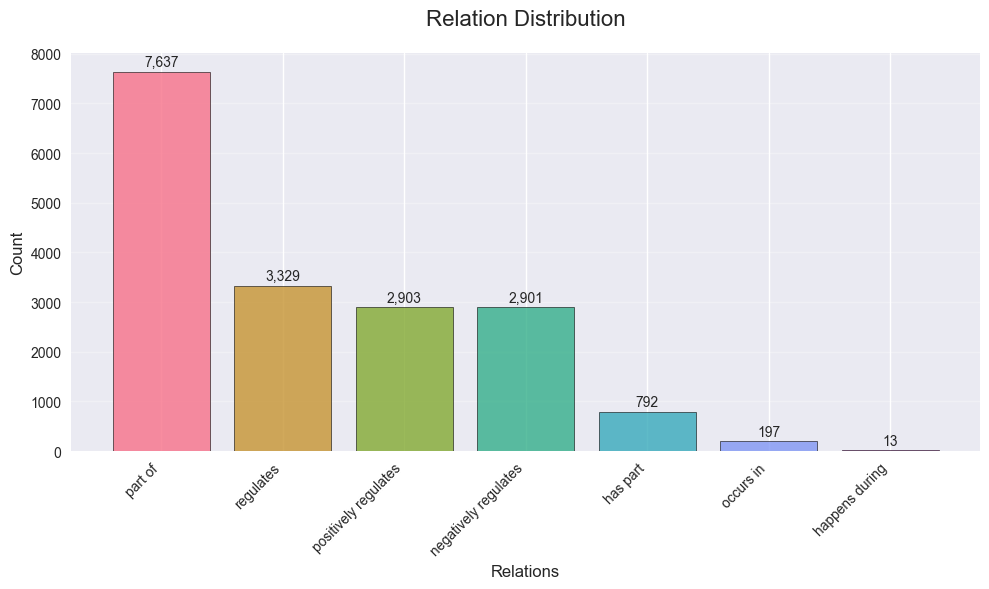

In [13]:
# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create figure with better proportions
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

# Bar chart improvements
bars = ax1.bar(range(len(relation_counts)), relation_counts.values, 
               color=sns.color_palette("husl", len(relation_counts)),
               edgecolor='black', linewidth=0.5, alpha=0.8)

# Add value labels on top of bars
for i, (bar, value) in enumerate(zip(bars, relation_counts.values)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{value:,}', ha='center', va='bottom')

ax1.set_title('Relation Distribution', fontsize=16, pad=20)
ax1.set_xlabel('Relations', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xticks(range(len(relation_counts)))
ax1.set_xticklabels(relation_counts.index, rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [3]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['r'])

train_df, dev_df = train_test_split(
    df, test_size=0.2, random_state=10, stratify=df['label_id']
)

print(f"Train: {len(train_df)}, Dev: {len(dev_df)}")


Train: 14217, Dev: 3555


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, f1_score
import numpy as np
from collections import defaultdict

class BioBERTkNN:
    def __init__(self, model_name='dmis-lab/biobert-v1.1', k=5, device='cuda'):
        self.model = SentenceTransformer(model_name, device=device)
        self.k = k
        self.train_embeddings = None
        self.train_labels = None
        
    def encode_pairs(self, head_terms, tail_terms):
        texts = [f"{h} [SEP] {t}" for h, t in zip(head_terms, tail_terms)]
        return self.model.encode(texts, show_progress_bar=True)
    
    def fit(self, train_df):
        self.train_embeddings = self.encode_pairs(train_df['h'], train_df['t'])
        self.train_labels = train_df['r'].values
        
    def predict(self, test_df):
        test_embeddings = self.encode_pairs(test_df['h'], test_df['t'])
        
        # Vectorized cosine similarity computation for all test samples at once
        similarities = cosine_similarity(test_embeddings, self.train_embeddings)
        
        # Get top-k indices for all test samples at once
        top_k_indices = np.argpartition(similarities, -self.k, axis=1)[:, -self.k:]
        
        predictions = []
        for i, test_indices in enumerate(top_k_indices):
            # Get similarities and labels for top-k neighbors
            test_similarities = similarities[i, test_indices]
            top_k_labels = self.train_labels[test_indices]
            
            # Aggregate scores by label
            label_scores = defaultdict(float)
            for label, sim in zip(top_k_labels, test_similarities):
                label_scores[label] += sim
            
            predicted_label = max(label_scores, key=label_scores.get)
            predictions.append(predicted_label)
            
        return predictions

knn_model = BioBERTkNN(k=5, device='cuda')
knn_model.fit(train_df)
knn_predictions = knn_model.predict(dev_df)

true_labels = dev_df['r'].values
macro_f1 = f1_score(true_labels, knn_predictions, average='macro')
micro_f1 = f1_score(true_labels, knn_predictions, average='micro')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Micro F1: {micro_f1:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, knn_predictions))


No sentence-transformers model found with name dmis-lab/biobert-v1.1. Creating a new one with mean pooling.
Batches: 100%|██████████| 112/112 [00:07<00:00, 15.64it/s]


Macro F1: 0.4631
Micro F1: 0.4925

Classification Report:
                      precision    recall  f1-score   support

      happens during       1.00      0.67      0.80         3
            has part       0.61      0.46      0.52       158
negatively regulates       0.16      0.17      0.16       580
           occurs in       0.67      0.46      0.55        39
             part of       0.84      0.88      0.86      1528
positively regulates       0.14      0.16      0.15       581
           regulates       0.25      0.18      0.21       666

            accuracy                           0.49      3555
           macro avg       0.52      0.42      0.46      3555
        weighted avg       0.49      0.49      0.49      3555



In [16]:
import json
import pandas as pd
import numpy as np
from collections import defaultdict
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

class ImprovedRelationClassifier:
    def __init__(self, model_name='dmis-lab/biobert-v1.1', 
                 use_class_weights=True, use_smote=False, device='cuda'):
        self.model_name = model_name
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.sentence_model = SentenceTransformer(model_name, device=device)
        self.use_class_weights = use_class_weights
        self.use_smote = use_smote
        self.class_weights = None
        self.train_embeddings = None
        self.train_labels = None
        
    def create_enhanced_text_representation(self, head_terms, tail_terms, relations=None):
        """Create enhanced text representations using multiple strategies"""
        representations = []
        
        for i, (h, t) in enumerate(zip(head_terms, tail_terms)):
            # Strategy 1: Template-based representation
            templates = [
                f"The relationship between '{h}' and '{t}' is:",
                f"'{h}' relates to '{t}' by:",
                f"How does '{h}' connect to '{t}'?",
                f"'{h}' [MASK] '{t}'",  # For masked language model understanding
                f"biological relationship: {h} -> {t}",
                f"{h} [SEP] {t}",  # Original format
            ]
            
            # Strategy 2: Add domain-specific context
            if 'regulation' in h.lower() or 'regulation' in t.lower():
                templates.append(f"regulatory process: {h} affects {t}")
            if 'part' in h.lower() or 'part' in t.lower():
                templates.append(f"structural relationship: {h} is component of {t}")
            if 'occurs' in h.lower() or 'process' in h.lower():
                templates.append(f"temporal/spatial: {h} happens in context of {t}")
                
            representations.append(templates)
            
        return representations
    
    def encode_with_multiple_strategies(self, head_terms, tail_terms):
        """Encode using multiple representation strategies and ensemble"""
        # Strategy 1: Enhanced sentence transformer encoding
        enhanced_texts = []
        for h, t in zip(head_terms, tail_terms):
            # Create more informative text
            text = f"biological relation between {h} and {t}"
            enhanced_texts.append(text)
        
        embeddings1 = self.sentence_model.encode(enhanced_texts, show_progress_bar=True)
        
        # Strategy 2: BioBERT-style encoding with special tokens
        bio_texts = [f"[CLS] {h} [SEP] {t} [SEP]" for h, t in zip(head_terms, tail_terms)]
        embeddings2 = self.sentence_model.encode(bio_texts, show_progress_bar=True)
        
        # Strategy 3: Template-based encoding
        template_texts = [f"The relationship type between {h} and {t} in biological context" 
                         for h, t in zip(head_terms, tail_terms)]
        embeddings3 = self.sentence_model.encode(template_texts, show_progress_bar=True)
        
        # Ensemble the embeddings
        ensemble_embeddings = np.concatenate([embeddings1, embeddings2, embeddings3], axis=1)
        return ensemble_embeddings
    
    def apply_class_balancing(self, train_df):
        """Apply class balancing techniques"""
        if self.use_smote:
            # Apply SMOTE for oversampling minority classes
            X = self.train_embeddings
            y = train_df['label_id'].values
            
            smote = SMOTE(k_neighbors=3)  # Reduced k_neighbors for small classes
            X_resampled, y_resampled = smote.fit_resample(X, y)
            
            # Convert back to labels
            label_encoder = LabelEncoder()
            label_encoder.fit(train_df['r'])
            resampled_labels = label_encoder.inverse_transform(y_resampled)
            
            return X_resampled, resampled_labels
        
        return self.train_embeddings, train_df['r'].values
    
    def compute_class_weights(self, labels):
        """Compute class weights for handling imbalance"""
        unique_labels = np.unique(labels)
        class_weights = compute_class_weight('balanced', classes=unique_labels, y=labels)
        return dict(zip(unique_labels, class_weights))
    
    def fit(self, train_df):
        """Fit the model with enhanced features and class balancing"""
        # Generate enhanced embeddings
        self.train_embeddings = self.encode_with_multiple_strategies(
            train_df['h'], train_df['t']
        )
        
        # Apply class balancing if requested
        if self.use_smote or self.use_class_weights:
            self.train_embeddings, self.train_labels = self.apply_class_balancing(train_df)
            
            if self.use_class_weights:
                self.class_weights = self.compute_class_weights(self.train_labels)
        else:
            self.train_labels = train_df['r'].values
    
    def predict_with_confidence(self, test_df, k_values=[3, 5, 7, 9], use_weighted_voting=True):
        """Enhanced prediction with improved similarity computation and ensemble voting"""
        test_embeddings = self.encode_with_multiple_strategies(test_df['h'], test_df['t'])
        
        # Vectorized cosine similarity computation for all test samples at once
        similarities = cosine_similarity(test_embeddings, self.train_embeddings)
        
        predictions = []
        confidences = []
        
        for i, test_similarities in enumerate(similarities):
            # Multi-k ensemble prediction with adaptive weighting
            ensemble_scores = defaultdict(float)
            total_weight = 0
            
            for k_idx, k in enumerate(k_values):
                # Get top-k indices
                top_k_indices = np.argpartition(test_similarities, -k)[-k:]
                top_k_labels = self.train_labels[top_k_indices]
                top_k_sims = test_similarities[top_k_indices]
                
                # Adaptive k-weight: smaller k gets higher weight for precision
                k_weight = 1.0 / (k_idx + 1)
                
                # Aggregate scores with similarity weighting
                label_scores = defaultdict(float)
                for label, sim in zip(top_k_labels, top_k_sims):
                    # Apply class weight if available
                    class_weight = 1.0
                    if self.use_class_weights and label in self.class_weights:
                        class_weight = 1.0 / max(self.class_weights[label], 0.1)  # Prevent division by very small numbers
                    
                    # Exponential similarity weighting for better discrimination
                    weighted_sim = np.exp(sim * 2) * class_weight
                    label_scores[label] += weighted_sim
                
                # Normalize scores for this k and add to ensemble
                if label_scores:
                    max_score = max(label_scores.values())
                    for label, score in label_scores.items():
                        normalized_score = score / max_score
                        ensemble_scores[label] += normalized_score * k_weight
                
                total_weight += k_weight
            
            # Normalize ensemble scores
            if ensemble_scores and total_weight > 0:
                for label in ensemble_scores:
                    ensemble_scores[label] /= total_weight
                
                # Get prediction and confidence
                predicted_label = max(ensemble_scores, key=ensemble_scores.get)
                
                # Calculate confidence as the ratio of top score to second highest
                sorted_scores = sorted(ensemble_scores.values(), reverse=True)
                if len(sorted_scores) > 1:
                    confidence = sorted_scores[0] / (sorted_scores[0] + sorted_scores[1])
                else:
                    confidence = sorted_scores[0] if sorted_scores else 0.0
                
                predictions.append(predicted_label)
                confidences.append(confidence)
            else:
                # Fallback: use most similar single neighbor
                best_idx = np.argmax(test_similarities)
                predictions.append(self.train_labels[best_idx])
                confidences.append(test_similarities[best_idx])
        
        return predictions, confidences

def main():
    # Load data
    with open('SubTask C.2(FS) - GO/go_train_re_pairs.json', 'r') as f:
        train_data = json.load(f)
    
    with open('SubTask C.2(FS) - GO/go_test_re_pairs.json', 'r') as f:
        test_data = json.load(f)
    
    with open('SubTask C.2(FS) - GO/go_train_re_relations.txt', 'r') as f:
        relation_labels = [line.strip() for line in f.readlines()]
    
    # Data preprocessing
    combined_data = train_data + test_data
    df = pd.DataFrame(combined_data)
    
    # Create label encoder for original relations
    label_encoder = LabelEncoder()
    df['label_id'] = label_encoder.fit_transform(df['r'])
    
    # Split data
    train_df, dev_df = train_test_split(
        df, test_size=0.2, 
        stratify=df['label_id']
    )
    
    print(f"Train: {len(train_df)}, Dev: {len(dev_df)}")
    print(f"Relation distribution in training:\n{train_df['r'].value_counts()}")
    
    # Train improved models
    print("\n=== Training Enhanced Model ===")
    
    # Model 1: Enhanced with class weights
    model1 = ImprovedRelationClassifier(use_class_weights=True, use_smote=False, device='cuda')
    model1.fit(train_df)
    predictions1, confidences1 = model1.predict_with_confidence(dev_df)
    
    # Model 2: Enhanced with SMOTE
    model2 = ImprovedRelationClassifier(use_class_weights=False, use_smote=True, device='cuda')
    model2.fit(train_df)
    predictions2, confidences2 = model2.predict_with_confidence(dev_df)
    
    # Ensemble predictions with confidence-based weighting
    final_predictions = []
    for i, (pred1, pred2, conf1, conf2) in enumerate(zip(predictions1, predictions2, confidences1, confidences2)):
        # Weight predictions by confidence
        if conf1 > conf2 * 1.1:  # Add small bias to prefer class-weighted model
            final_predictions.append(pred1)
        elif conf2 > conf1 * 1.1:
            final_predictions.append(pred2)
        else:
            # If confidences are similar, use class-weighted model as default
            final_predictions.append(pred1)
    
    # Evaluate
    true_labels = dev_df['r'].values
    
    print("\n=== Model 1 (Class Weights) Results ===")
    macro_f1_1 = f1_score(true_labels, predictions1, average='macro')
    micro_f1_1 = f1_score(true_labels, predictions1, average='micro')
    print(f"Macro F1: {macro_f1_1:.4f}, Micro F1: {micro_f1_1:.4f}")
    
    print("\n=== Model 2 (SMOTE) Results ===")
    macro_f1_2 = f1_score(true_labels, predictions2, average='macro')
    micro_f1_2 = f1_score(true_labels, predictions2, average='micro')
    print(f"Macro F1: {macro_f1_2:.4f}, Micro F1: {micro_f1_2:.4f}")
    
    print("\n=== Ensemble Results ===")
    macro_f1_ensemble = f1_score(true_labels, final_predictions, average='macro')
    micro_f1_ensemble = f1_score(true_labels, final_predictions, average='micro')
    print(f"Macro F1: {macro_f1_ensemble:.4f}, Micro F1: {micro_f1_ensemble:.4f}")
    
    print("\nDetailed Classification Report:")
    print(classification_report(true_labels, final_predictions))
    
    return model1, model2

if __name__ == "__main__":
    model1, model2 = main()

Train: 14217, Dev: 3555
Relation distribution in training:
r
part of                 6109
regulates               2663
positively regulates    2322
negatively regulates    2321
has part                 634
occurs in                158
happens during            10
Name: count, dtype: int64

=== Training Enhanced Model ===


No sentence-transformers model found with name dmis-lab/biobert-v1.1. Creating a new one with mean pooling.
Batches: 100%|██████████| 112/112 [00:08<00:00, 12.98it/s]
No sentence-transformers model found with name dmis-lab/biobert-v1.1. Creating a new one with mean pooling.
Batches: 100%|██████████| 112/112 [00:08<00:00, 12.47it/s]



=== Model 1 (Class Weights) Results ===
Macro F1: 0.4567, Micro F1: 0.5541

=== Model 2 (SMOTE) Results ===
Macro F1: 0.4300, Micro F1: 0.4166

=== Ensemble Results ===
Macro F1: 0.4562, Micro F1: 0.5030

Detailed Classification Report:
                      precision    recall  f1-score   support

      happens during       1.00      0.67      0.80         3
            has part       0.79      0.61      0.69       158
negatively regulates       0.11      0.11      0.11       580
           occurs in       0.48      0.33      0.39        39
             part of       0.81      0.93      0.87      1528
positively regulates       0.12      0.12      0.12       581
           regulates       0.24      0.20      0.22       666

            accuracy                           0.50      3555
           macro avg       0.51      0.42      0.46      3555
        weighted avg       0.47      0.50      0.49      3555



In [ ]:
import json
import pandas as pd
import numpy as np
from collections import defaultdict
import torch
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

class ImprovedBioBERTkNN:
    def __init__(self, model_name='dmis-lab/biobert-v1.1', k=5, device='cuda', 
                 use_weighted_voting=True, ensemble_k=False):

        self.model = SentenceTransformer(model_name, device=device)
        self.k = k
        self.use_weighted_voting = use_weighted_voting
        self.ensemble_k = ensemble_k
        self.k_values = [3, 5, 7] if ensemble_k else [k]
        self.train_embeddings = None
        self.train_labels = None
        
    def encode_pairs(self, head_terms, tail_terms):
        """Create better text representations for biomedical relations"""
        # Strategy 1: Simple and effective - just use the BioBERT format
        texts = [f"{h} [SEP] {t}" for h, t in zip(head_terms, tail_terms)]
        
        # Strategy 2: Add minimal domain context without over-engineering
        enhanced_texts = []
        for h, t in zip(head_terms, tail_terms):
            # Add biological context cue
            enhanced_text = f"biological relation: {h} [SEP] {t}"
            enhanced_texts.append(enhanced_text)
        
        # Encode both versions
        embeddings1 = self.model.encode(texts, show_progress_bar=True)
        embeddings2 = self.model.encode(enhanced_texts, show_progress_bar=True)
        
        # Simple average ensemble instead of concatenation
        # This preserves the original embedding dimension
        final_embeddings = (embeddings1 + embeddings2) / 2
        
        return final_embeddings
    
    def fit(self, train_df):
        """Fit the model with improved embeddings"""
        self.train_embeddings = self.encode_pairs(train_df['h'], train_df['t'])
        self.train_labels = train_df['r'].values
        
    def predict(self, test_df):
        """Predict with improved voting strategy"""
        test_embeddings = self.encode_pairs(test_df['h'], test_df['t'])
        
        # Vectorized cosine similarity computation
        similarities = cosine_similarity(test_embeddings, self.train_embeddings)
        
        predictions = []
        
        for i, test_similarities in enumerate(similarities):
            if self.ensemble_k:
                # Ensemble across different k values
                ensemble_scores = defaultdict(float)
                
                for k_val in self.k_values:
                    top_k_indices = np.argpartition(test_similarities, -k_val)[-k_val:]
                    top_k_labels = self.train_labels[top_k_indices]
                    top_k_sims = test_similarities[top_k_indices]
                    
                    # Weighted voting within this k
                    if self.use_weighted_voting:
                        for label, sim in zip(top_k_labels, top_k_sims):
                            ensemble_scores[label] += sim / len(self.k_values)
                    else:
                        # Simple voting
                        for label in top_k_labels:
                            ensemble_scores[label] += 1.0 / len(self.k_values)
                
                predicted_label = max(ensemble_scores, key=ensemble_scores.get)
            else:
                # Single k value prediction
                top_k_indices = np.argpartition(test_similarities, -self.k)[-self.k:]
                top_k_labels = self.train_labels[top_k_indices]
                
                if self.use_weighted_voting:
                    top_k_sims = test_similarities[top_k_indices]
                    label_scores = defaultdict(float)
                    for label, sim in zip(top_k_labels, top_k_sims):
                        label_scores[label] += sim
                    predicted_label = max(label_scores, key=label_scores.get)
                else:
                    # Simple majority voting
                    from collections import Counter
                    label_counts = Counter(top_k_labels)
                    predicted_label = label_counts.most_common(1)[0][0]
            
            predictions.append(predicted_label)
            
        return predictions

def main():
    # Load data
    with open('SubTask C.2(FS) - GO/go_train_re_pairs.json', 'r') as f:
        train_data = json.load(f)
    
    with open('SubTask C.2(FS) - GO/go_test_re_pairs.json', 'r') as f:
        test_data = json.load(f)
    
    with open('SubTask C.2(FS) - GO/go_train_re_relations.txt', 'r') as f:
        relation_labels = [line.strip() for line in f.readlines()]
    
    # Data preprocessing
    combined_data = train_data + test_data
    df = pd.DataFrame(combined_data)
    
    # Encode labels
    label_encoder = LabelEncoder()
    df['label_id'] = label_encoder.fit_transform(df['r'])
    
    # Split data
    train_df, dev_df = train_test_split(
        df, test_size=0.2, random_state=42, 
        stratify=df['label_id']
    )
    
    print(f"Train: {len(train_df)}, Dev: {len(dev_df)}")
    print(f"Relation distribution in training:\n{train_df['r'].value_counts()}")
    
    # Train models
    print("\n=== Training Models ===")
    
    # Model 1: Original simple BioBERT k-NN
    print("Training Simple BioBERT k-NN...")
    simple_model = ImprovedBioBERTkNN(k=5, use_weighted_voting=True, ensemble_k=False)
    simple_model.fit(train_df)
    simple_predictions = simple_model.predict(dev_df)
    
    # Model 2: Enhanced BioBERT k-NN with ensemble
    print("Training Enhanced BioBERT k-NN...")
    enhanced_model = ImprovedBioBERTkNN(k=5, use_weighted_voting=True, ensemble_k=True)
    enhanced_model.fit(train_df)
    enhanced_predictions = enhanced_model.predict(dev_df)
    
    # Evaluate all models
    true_labels = dev_df['r'].values
    
    print("\n=== Results Comparison ===")
    
    # Simple model
    macro_f1_simple = f1_score(true_labels, simple_predictions, average='macro')
    micro_f1_simple = f1_score(true_labels, simple_predictions, average='micro')
    print(f"Simple BioBERT k-NN - Macro F1: {macro_f1_simple:.4f}, Micro F1: {micro_f1_simple:.4f}")
    
    # Enhanced model
    macro_f1_enhanced = f1_score(true_labels, enhanced_predictions, average='macro')
    micro_f1_enhanced = f1_score(true_labels, enhanced_predictions, average='micro')
    print(f"Enhanced k-NN - Macro F1: {macro_f1_enhanced:.4f}, Micro F1: {micro_f1_enhanced:.4f}")
    
    print("\nDetailed Classification Report (Best Model):")
    best_predictions = enhanced_predictions if macro_f1_enhanced > macro_f1_simple else simple_predictions
    print(classification_report(true_labels, best_predictions))
    
    # Show detailed classification reports for both models
    print("\n=== Detailed Classification Reports ===")

    print("\n1. Simple BioBERT k-NN Model:")
    print("=" * 50)
    print(classification_report(true_labels, simple_predictions))

    print("\n2. Enhanced BioBERT k-NN Model:")
    print("=" * 50)
    print(classification_report(true_labels, enhanced_predictions))

    # Additional comparison metrics
    print("\n=== Model Comparison Summary ===")
    print(f"Simple Model  - Macro F1: {macro_f1_simple:.4f}, Micro F1: {micro_f1_simple:.4f}")
    print(f"Enhanced Model - Macro F1: {macro_f1_enhanced:.4f}, Micro F1: {micro_f1_enhanced:.4f}")

    improvement_macro = ((macro_f1_enhanced - macro_f1_simple) / macro_f1_simple) * 100
    improvement_micro = ((micro_f1_enhanced - micro_f1_simple) / micro_f1_simple) * 100

    print(f"\nImprovement with Enhanced Model:")
    print(f"Macro F1: {improvement_macro:+.2f}%")
    print(f"Micro F1: {improvement_micro:+.2f}%")

    return simple_model, enhanced_model

if __name__ == "__main__":
    simple_model, enhanced_model = main()

Train: 14217, Dev: 3555
Relation distribution in training:
r
part of                 6109
regulates               2663
positively regulates    2322
negatively regulates    2321
has part                 634
occurs in                158
happens during            10
Name: count, dtype: int64

=== Training Models ===
Training Simple BioBERT k-NN...


No sentence-transformers model found with name dmis-lab/biobert-v1.1. Creating a new one with mean pooling.
Batches: 100%|██████████| 112/112 [00:07<00:00, 14.36it/s]
No sentence-transformers model found with name dmis-lab/biobert-v1.1. Creating a new one with mean pooling.


Training Enhanced BioBERT k-NN...


Batches: 100%|██████████| 112/112 [00:08<00:00, 13.55it/s]



=== Results Comparison ===
Simple BioBERT k-NN - Macro F1: 0.4874, Micro F1: 0.5089
Enhanced k-NN - Macro F1: 0.5101, Micro F1: 0.5347

Detailed Classification Report (Best Model):
                      precision    recall  f1-score   support

      happens during       1.00      0.67      0.80         3
            has part       0.69      0.51      0.59       158
negatively regulates       0.25      0.26      0.25       580
           occurs in       0.62      0.59      0.61        39
             part of       0.84      0.90      0.87      1528
positively regulates       0.20      0.25      0.22       581
           regulates       0.29      0.20      0.24       666

            accuracy                           0.53      3555
           macro avg       0.56      0.48      0.51      3555
        weighted avg       0.53      0.53      0.53      3555


=== Detailed Classification Reports ===

1. Simple BioBERT k-NN Model:
                      precision    recall  f1-score   support